<a href="https://colab.research.google.com/github/theQuert/inlpfun/blob/master/Demo/Sentiment_Analysis_of_Covid19_Vaccination_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi
!pip3 install gwpy --quiet

Thu Dec 16 07:21:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%%capture
!pip3 install pyLDAvis spacy cssselect sentence-transformers bertopic bertopic[visualization]
!python3 -m spacy download en_core_web_sm
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, json
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import time, datetime
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stemmer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
# import pyLDAvis
# import pyLDAvis.gensim_models

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print(device)

cuda


#### Training

In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/NCCU_BD21
df = pd.read_csv('tweet_dataset.csv')

/content/drive/MyDrive/Colab Notebooks/NCCU_BD21


In [6]:
# df.head()

We only extract `text` and `new_sentiment`

In [7]:
train = pd.DataFrame()
train['text'] = df['text']
train['Sentiment'] = df['new_sentiment']

Drop NaN

In [8]:
train = train.dropna()
train.isnull().sum()

text         0
Sentiment    0
dtype: int64

In [9]:
train['Sentiment'] = train['Sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])

In [10]:
train.head()

,text,Sentiment
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,2
4,We want to trade with someone who has Houston...,1
5,Re-pinging : why didn`t you go to prom? BC my ...,0


#### Importing BERT Tokenizer

In [11]:
%%capture
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

#### Preprocessing

In [12]:
for tweet in train['text']:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    max_len = max(0, len(input_ids))

print('Max sequence length: ', max_len)

Max sequence length:  33


In [13]:
%%capture
input_ids = []
attention_masks = []

for sent in train['text']:
    encoded_dict = tokenizer.encode_plus(
        sent,
        # padding=True, 
        truncation=True,
        max_length=110,
        pad_to_max_length=True,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['Sentiment'].tolist())

#### Datasets and DataLoaders

In [14]:
# Create the dataset wrapping tensors 
# input_ids, attention_masks, labels
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [15]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size = batch_size
)

In [16]:
%%capture
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

#### Optimizer and Scheduler

In [17]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps=1e-8)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [18]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### Training Loop

In [ ]:
epochs=5

model.to(device)

training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids = None,
                       attention_mask = b_attention_mask,
                       labels = b_labels,
                       return_dict=True)
        
        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epcoh took: {:}".format(training_time))

In [ ]:
print("Running Validation...")
t0 = time.time()

model.eval()

total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [21]:
# Save tuned model
torch.save(model,'tuned_model.pt')

#### Prediction

In [22]:
df_vax = pd.read_csv('vaccination_all_tweets.csv')
df_vax.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [23]:
#@title Time Inputs for observation
df_vax_weeks = df_vax.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-11-01 0:00:00' #@param {type: "string"}
end_date = '2021-11-20 23:59:59' #@param {type: "string"}
duration = (df_vax_weeks['date'] > start_date) & (df_vax_weeks['date'] <= end_date)
df_vax_weeks = df_vax_weeks.loc[duration]

In [24]:
# df_vax_weeks.head()
# df_vax_weeks.shape

In [25]:
# df_vax_weeks.head()

In [26]:
# extract texts
vax_tweets = df_vax_weeks['text']

#### Pre-processing tweets

In [27]:
%%capture
input_ids = []
attention_masks = []

for tweet in vax_tweets:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    tweet = re.sub(r'\S+\.com\S+','', tweet)
    tweet = re.sub(r'\@\w+','', tweet)
    tweet = re.sub("\ ","", tweet)
    tweet = re.sub("\'","", tweet)
    tweet = re.sub("\\n'","", tweet)
    tweet = re.sub('#\w+', '', tweet)

    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens = True,
        max_length = 110,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, 0)
attention_masks = torch.cat(attention_masks, 0)

#### Dataset and DataLoader

In [28]:
vax_dataset = TensorDataset(input_ids, attention_masks)
vax_dataloader = DataLoader(
    vax_dataset,
    sampler = SequentialSampler(vax_tweets),
    batch_size = batch_size
)

#### Prediction

In [29]:
print(f'Predicting sentiments for {len(input_ids)} vaccine tweets')
model.eval()

predictions = []

for batch in vax_dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  logits=np.argmax(logits,axis=1)
  
  for i in range(len(logits)):
      predictions.append(logits[i])
print('DONE')

Predicting sentiments for 12692 vaccine tweets
DONE


In [30]:
df_vax_weeks['Sentiment'] = predictions
df_vax_weeks = df_vax_weeks.dropna()
df_vax_weeks.isnull().sum()
# df_vax_weeks.head()

id                  0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
retweets            0
favorites           0
is_retweet          0
Sentiment           0
dtype: int64

In [31]:
# df_vax_weeks.info()

In [32]:
vax = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet'], axis=1)
# Concern saving the followers for more analysis

In [33]:
# vax.head()

In [34]:
%%capture
vax['text'] = vax['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
vax['text'] = vax['text'].str.replace("\\n'", "", regex=True)

In [35]:
# vax['text'].head()

In [36]:
vax['Sentiment'] = vax['Sentiment'].replace([0, 1, 2], ['negative', 'neutral', 'positive'])
# vax['Sentiment'] = vax['Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

<AxesSubplot:>

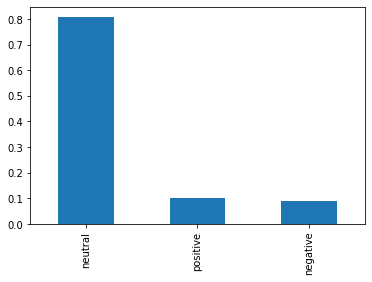

In [37]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [38]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].replace(['negative', 'neutral', 'positive'],
                                            [-1, 0, 1])
# vax['Sentiment'] = vax['Sentiment'].map({'negative': -1, 'nrutral': 0, 'positive': 1})

In [39]:
# vax.head()

<AxesSubplot:>

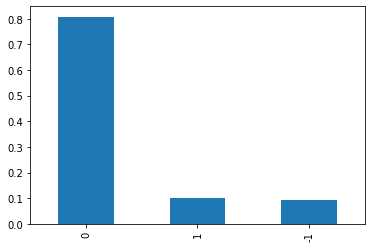

In [40]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [41]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik', 'johnson']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine'] = all_vax
sentiments = list()

#### Vaccine with Time

In [42]:
def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    
    fg, axs = plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs, x='date', y='Sentiment', data=temp)
    axs.set_xlabel("Time", size=16)
    axs.set_ylabel("Sentiment", size=16)
    axs.set_title("Variance of Sentiment wrt Time", size=24)
    axs.grid()

#### Mean overall sentiment

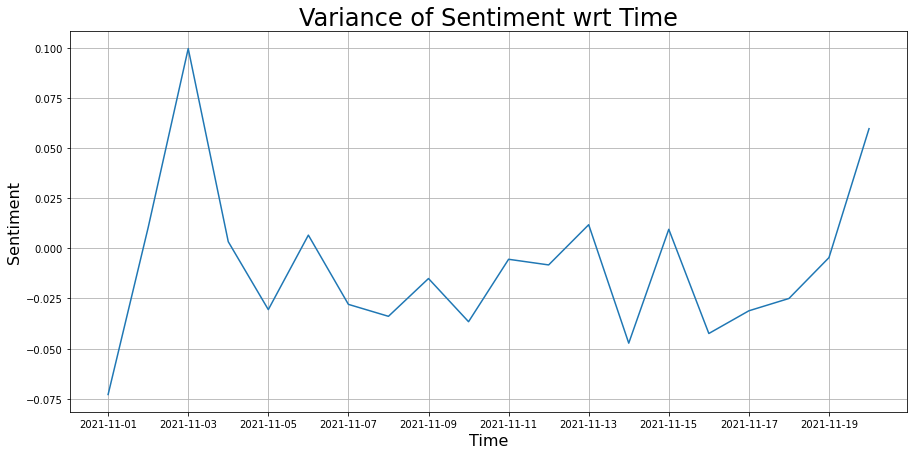

In [43]:
time_variance('all')

#### Moderna, Pfizer, JJ, COVAXIN, Sinopharm, Sinovac, AZ, Sputnik

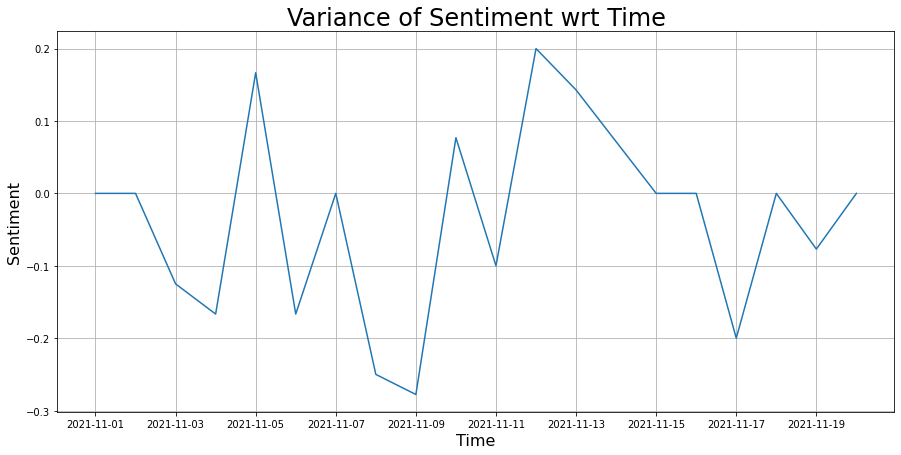

In [44]:
time_variance('moderna')

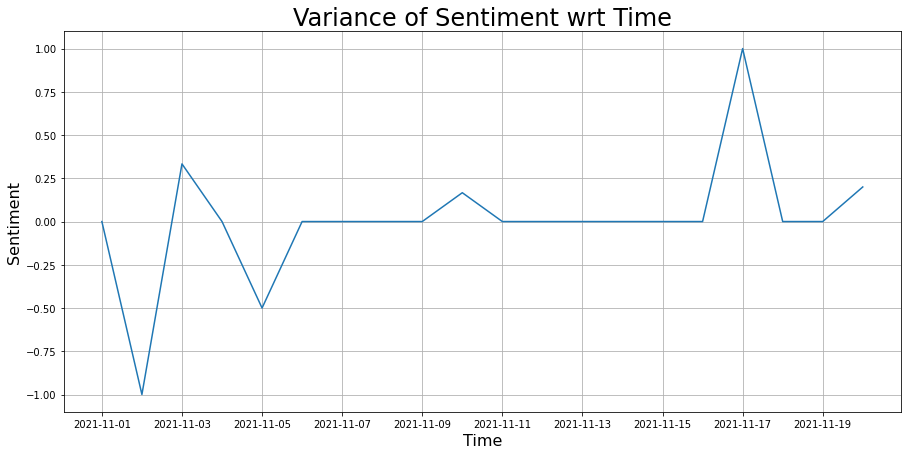

In [45]:
time_variance('pfizer')

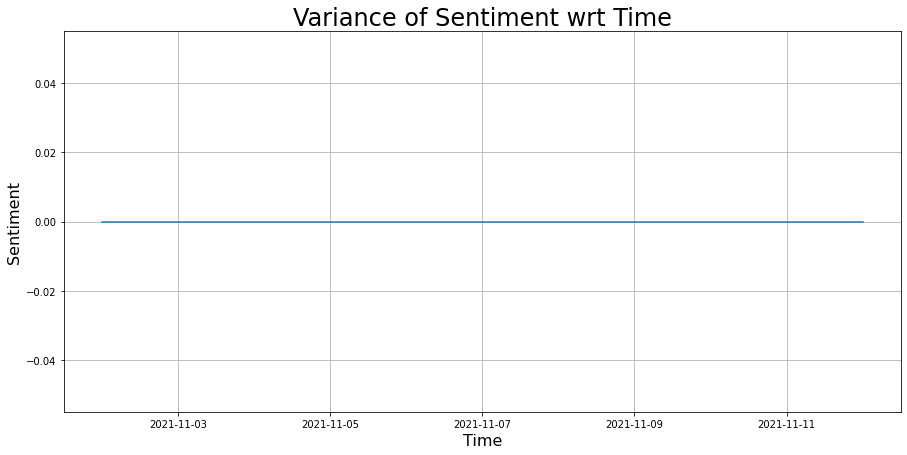

In [46]:
time_variance('johnson')    

In [47]:
# time_variance('covaxin')
# time_variance('sinovac')
# time_variance('sinopharm')
# time_variance('biontech')
# time_variance('oxford')
# time_variance('astrazeneca')
# time_variance('sputnik')

### Comparison among Countries

In [48]:
def time_variance_country(country) :
    count = vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title(f"Variance of Sentiment wrt Time",size=24)
    axs.grid()

In [49]:
# time_variance_country('india')

In [50]:
# time_variance_country('canada')

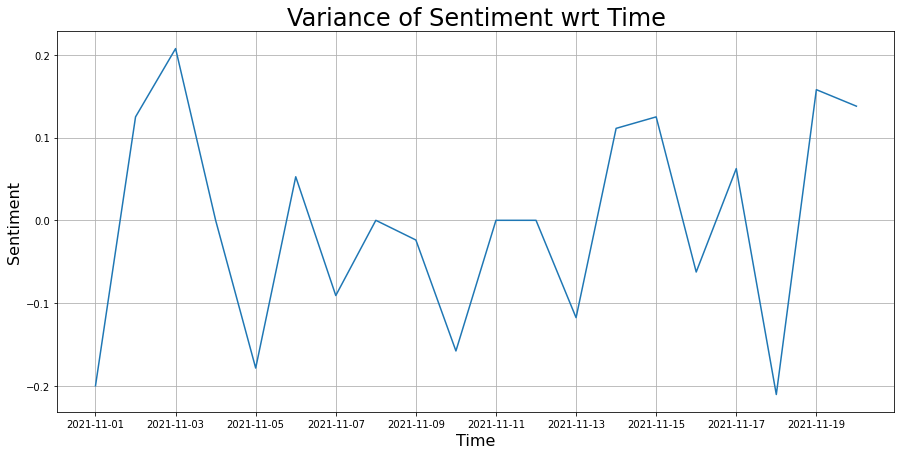

In [51]:
time_variance_country('usa')

The variance of sentiments in different countries seems to be more erratic. The varition might be the politics and economic matters among them.

# WordCloud

In [52]:
df_vax_tweets = vax_tweets.to_frame()
text_for_wd = str(df_vax_tweets['text'].values)

In [53]:
%%capture
text_for_wd_pro = re.sub(r"http\S+", "", text_for_wd)
text_for_wd_pro = re.sub(r'\S+\.com\S+','', text_for_wd_pro)
text_for_wd_pro = re.sub(r'\@\w+','', text_for_wd_pro)
text_for_wd_pro = re.sub("\ ","", text_for_wd_pro)
text_for_wd_pro = re.sub("\'","", text_for_wd_pro)
text_for_wd_pro = re.sub("\\n'","", text_for_wd_pro)

(-0.5, 999.5, 499.5, -0.5)

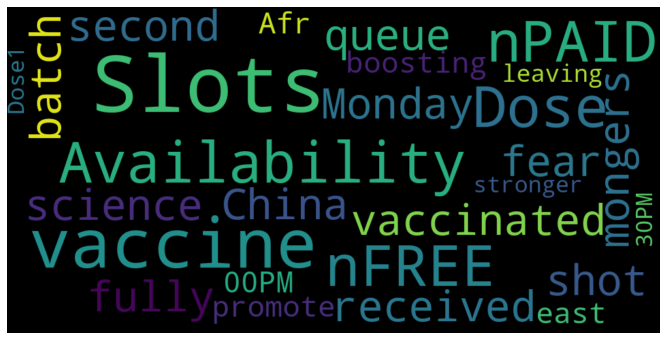

In [54]:
# without hashtags
words = str(vax['text'].values)
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

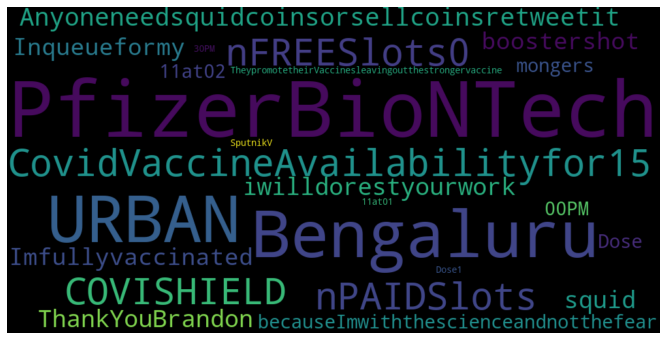

In [55]:
# with hashtags
words = text_for_wd_pro
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

# Topic Modeling

In [56]:
# df_vax_tweets.head()

In [57]:
%%capture
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace("\\n'", "", regex=True)

In [58]:
# df_vax_tweets.head()

In [59]:
df_vax_wks = df_vax_weeks.copy()

In [60]:
# df_vax_wks.head()

In [61]:
%%capture
# df_vax_wks['text'] = df_vax_wks['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace("\\n'", "", regex=True)

In [62]:
# df_vax_wks.head()

In [63]:
df_vax_wks = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet', 'id', 'user_location', 'user_verified', 'hashtags', 'retweets', 'favorites'], axis=1)

In [64]:
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)

In [65]:
# df_vax_wks.head()

In [66]:
%%capture
df_vax_pre = df_vax_wks.copy()
nlp = spacy.load('en_core_web_sm')

In [67]:
# Preprocessing texts
def make_lower_case(text):
    return text.lower()

def make_tokenize(text):
    return [w for w in text.split()]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    text = [w for w in text if not w in stop_words]
    texts = [w for w in text if w.isalpha()]
    texts = " ".join(texts)
    return texts

df_vax_pre['text'] = df_vax_pre['text'].apply(make_lower_case)
df_vax_pre['text'] = df_vax_pre['text'].apply(make_tokenize)
df_vax_pre['text'] = df_vax_pre['text'].apply(lemmatize)
df_vax_pre['text'] = df_vax_pre['text'].apply(remove_stop_words)

In [68]:
# df_vax_pre.head()

In [69]:
%%capture
# create embeddings with pre-trained model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

sentences = []
for id in range(df_vax_pre.shape[0]):
    sentences.append(df_vax_pre.iloc[id, :]['text'])

embeddings = model.encode(sentences, show_progress_bar=True)

In [70]:
%%capture
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=35, verbose=True)
topics, _ = topic_model.fit_transform(sentences)

In [71]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,1807,-1_covaxin_vaccine_newsom_california
1,0,463,0_booster_got_shot_moderna
2,1,378,1_sinovac_sinopharm_dos_million
3,2,355,2_urban_slot_paid_bengaluru
4,3,304,3_vaccine_moderna_vaccinated_vaccinemandate
5,4,251,4_getvaccinated_booster_moderna_got
6,5,248,5_approval_covaxin_approve_approved
7,6,244,6_vaccine_covaxin_traditional_vaccigen
8,7,242,7_moderna_logo_got_marketing
9,8,210,8_bbmp_bengaluru_availability_free


In [72]:
topic_nr = freq.iloc[3]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown below

[('urban', 0.160123470350687),
 ('slot', 0.13335847560442043),
 ('paid', 0.13073042557086906),
 ('bengaluru', 0.09174573455353416),
 ('availability', 0.0913611374979261),
 ('free', 0.09035198380058408),
 ('covishield', 0.0895491860783655),
 ('covidvaccine', 0.0832069108542341),
 ('', 1e-05),
 ('', 1e-05)]

In [73]:
%%capture
fig = topic_model.visualize_topics()

In [74]:
fig

In [75]:
fig.write_html("topic_fig.html")

In [76]:
scores_map = topic_model.visualize_barchart()

In [77]:
scores_map = topic_model.visualize_barchart()
scores_map.write_html('scores_fig.html')

In [78]:
%%capture
timestamps = df_vax_wks['date'].to_list()

topics_over_time = topic_model.topics_over_time(docs=sentences, 
                                                topics=topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

In [79]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [80]:
topic_over_time = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)
topic_over_time.write_html('topic_over_time.html')

In [81]:
topic_model.get_representative_docs()

{0: ['third booster moderna mixandmatch',
  'hour since got moderna booster side effect far sore arm mostly forgot',
  'moderna booster'],
 1: ['choice sinovac n sinopharm ha added uk vaccination',
  'canada allow entry traveller fully vaccinated sinopharm sinovac covaxin pfizer',
  'sinopharm recognised australian good news many sri thanks australia'],
 2: ['urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield'],
 3: ['trust vaccinated moderna',
  'moderna said week help manufacture vaccine bcuz faster',
  'thank fully vaccinated na mga estudyante miss guy lab yoh'],
 4: ['dose side covidvaccine moderna',
  'watch vaccinated vaccine boostershot moderna modernabooster',
  'im vaccine boosted want everyone know booster moderna'],
 5: ['covaxin finally get approval',
  'covaxin struggled get approval',
  'though co

In [82]:
#@title Use keywords to find topic
keywords_inputs = 'word_1 word_2' #@param {type: "string"}
topic_model.find_topics(keywords_inputs)

([9, 2, 37, 14, 0],
 [0.33672897390882073,
  0.33152346058805005,
  0.3296271320758175,
  0.32958479329203544,
  0.3179298794064088])

In [154]:
topic_model.visualize_heatmap()

In [84]:
%%capture
topic_model.save('topic_model')

# Trend Analysis

### Daily vaccinations

In [155]:
datadf_vax = pd.read_csv('country_vaccinations.csv')

In [86]:
# datadf_vax.head()

In [156]:
col_names = ['country', 'people_fully_vaccinated' ,'date', 'daily_vaccinations', 'vaccines']
datadf_vax_col = datadf_vax[col_names]
data_df_usa = datadf_vax_col.loc[datadf_vax['country']=='United States']

In [88]:
# data_df_usa.head()

In [157]:
#@title Time Inputs
df_vax_weeks_usa = data_df_usa.copy()
start_time = "'2021-10-31 23:59:59" #@param {type:"string"}
end_time = '2021-11-20 23:59:59' #@param {type:"string"}
duration = (df_vax_weeks_usa['date'] > start_time) & (df_vax_weeks_usa['date'] <= end_time)

df_vax_weeks_usa = df_vax_weeks_usa.loc[duration]

In [158]:
df_vax_weeks_usa.head()

,country,people_fully_vaccinated,date,daily_vaccinations,vaccines
57435,United States,3903.0,2020-12-13,NaN,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57436,United States,3999.0,2020-12-14,4331.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57437,United States,4209.0,2020-12-15,26536.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57438,United States,4598.0,2020-12-16,70637.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57439,United States,5168.0,2020-12-17,120620.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


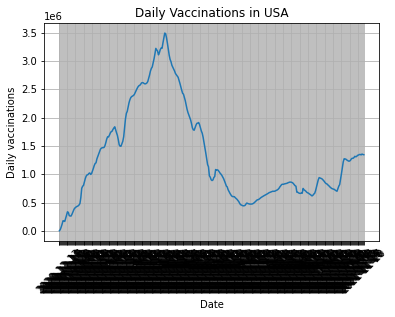

In [159]:
import matplotlib.pyplot as plt
axis_1 = df_vax_weeks_usa['date']
axis_2 = df_vax_weeks_usa['daily_vaccinations']
ano = df_vax_weeks_usa['people_fully_vaccinated']
plt.title("Daily Vaccinations in USA")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_1, axis_2)
plt.grid(True)
plt.show()
# plt.plot(axis_1, ano, '--')

### Daily vaccinations for each brand

In [92]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
df_brand = pd.read_csv('country_vaccinations_by_manufacturer.csv')

In [93]:
# df_brand.head()

In [94]:
df_brand = df_brand.loc[df_brand['location']=='United States']

In [95]:
#@title Time Inputs
df_brand_weeks = df_brand.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_time = '2021-10-31 23:59:59' #@param {type:"string"}
end_time = '2021-11-20 23:59:59' #@param {type:"string"}
duration = (df_brand_weeks['date'] > start_date) & (df_brand_weeks['date'] <= end_date)
df_brand_weeks = df_brand_weeks.loc[duration]

In [96]:
# df_brand_weeks.head()

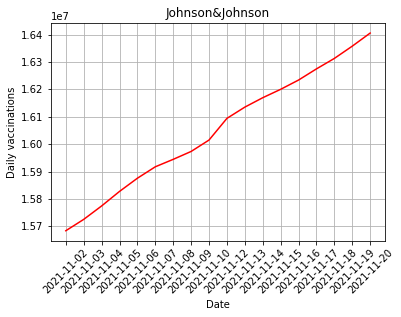

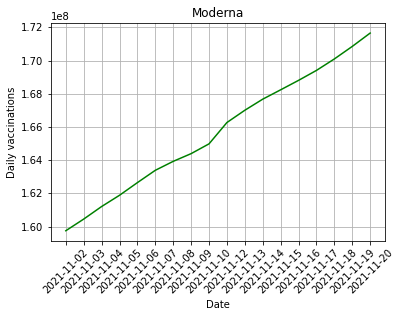

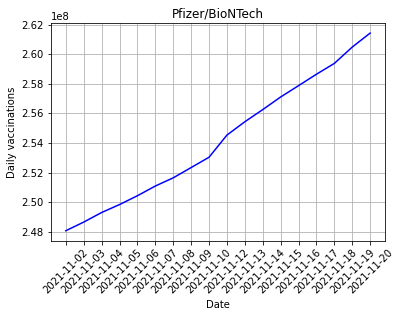

In [97]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
sel_jj = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Johnson&Johnson']
sel_moderna = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Moderna']
sel_pfizer = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Pfizer/BioNTech']

axis_0 = sel_jj['date']
axis_1 = sel_jj['total_vaccinations']
axis_2 = sel_moderna['total_vaccinations']
axis_3 = sel_pfizer['total_vaccinations']

plt.title("Johnson&Johnson")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_1, 'r', label='Johnson&Johnson')
plt.grid(True)
plt.show()

plt.title("Moderna")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_2, 'g', label='Moderna')
plt.grid(True)
plt.show()

plt.title("Pfizer/BioNTech")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_3, 'b', label='Pfizer/BioNTech')
plt.grid(True)
plt.show()

# plt.plot(axis_1, ano, '--')

In [98]:
variance_jj = []
variance_moderna = []
variance_pfizer = []
variance_jj.append(0)
variance_moderna.append(0)
variance_pfizer.append(0)
for id in range(1, sel_jj.shape[0]):
    variance_jj.append(((sel_jj.iloc[id, 3]-sel_jj.iloc[id-1, 3])/sel_jj.iloc[id-1, 3])*100)
for id in range(1, sel_moderna.shape[0]):
    variance_moderna.append(((sel_moderna.iloc[id, 3]-sel_moderna.iloc[id-1, 3])/sel_moderna.iloc[id-1, 3])*100)
for id in range(1, sel_pfizer.shape[0]):
    variance_pfizer.append(((sel_pfizer.iloc[id, 3]-sel_pfizer.iloc[id-1, 3])/sel_pfizer.iloc[id-1, 3])*100)

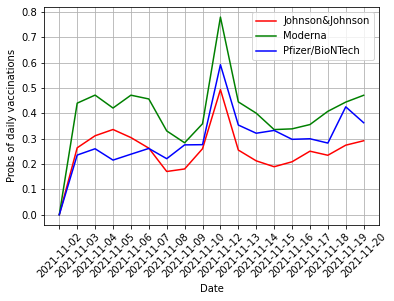

In [99]:
axis_0 = sel_jj['date']
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.plot(axis_0, variance_jj, 'r', label='Johnson&Johnson')
plt.plot(axis_0, variance_moderna, 'g', label='Moderna')
plt.plot(axis_0, variance_pfizer, 'b', label='Pfizer/BioNTech')
plt.legend(['Johnson&Johnson', 'Moderna', 'Pfizer/BioNTech'])
plt.ylabel("Probs of daily vaccinations")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### Pie chart for brands

In [100]:
row = sel_jj.shape[0]-1
sel_jj_total = sel_jj.iloc[row, 3]
sel_moderna_total = sel_moderna.iloc[row, 3]
sel_pfizer_total = sel_pfizer.iloc[row, 3]

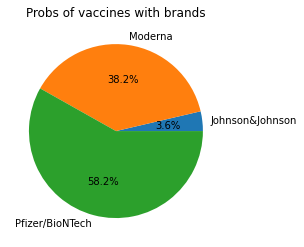

In [101]:
labels = ['Johnson&Johnson', 'Moderna', 'Pfizer/BioNTech']
size = [sel_jj_total, sel_moderna_total, sel_pfizer_total]
plt.pie(size , labels = labels,autopct='%1.1f%%')
plt.title('Probs of vaccines with brands')
plt.show()

# Duration of interest

### Variance of sentiments

In [102]:
def sents_var_plot(vacc) :
    if vacc == 'all':
        vacc = vax
    else:   
        vacc = vax[vax['text'].str.lower().str.contains(vacc)] # vax: store the tweets contain vacc in list
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti = list()
    var = list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    var.append(0)
    
    for idx in range(1, len(senti)):
        var.append(senti[idx]-senti[idx-1])
 
    axis_0 = temp['date']
    fig, ax = plt.subplots()
    plt.xticks(rotation=45)
    plt.plot(axis_0, var, 'r', label=vacc)

    plt.ylabel("Sentiment Probs of daily vaccinations")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

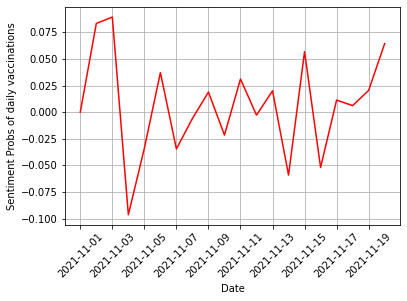

In [103]:
sents_var_plot('all')

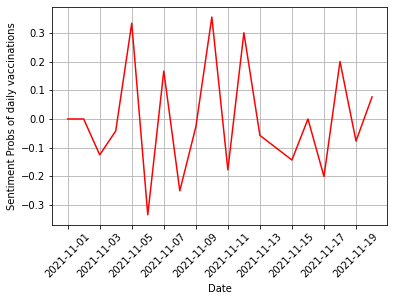

In [104]:
sents_var_plot('moderna')

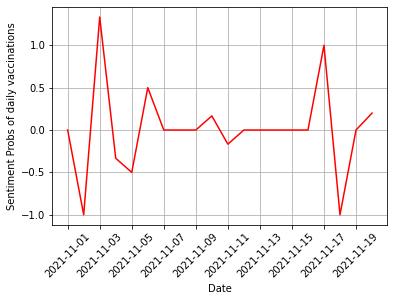

In [105]:
sents_var_plot('pfizer')

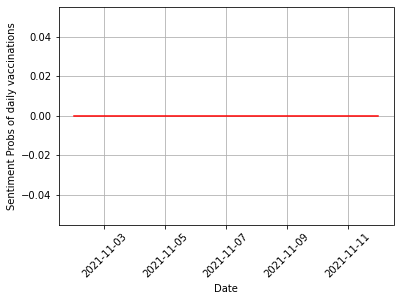

In [106]:
sents_var_plot('johnson')

In [107]:
# automatic reporting mechanism: sentiment
def sents_var_rep(vacc):
    if vacc == 'all':
        vacc = vax
    else :   
        vacc = vax[vax['text'].str.lower().str.contains(vacc)] # vax: store the tweets contain vacc in list
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti = list()
    var = list()
    date_alert = list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())
    temp['Sentiment'] = senti
    var.append(0)

    for idx in range(1, len(senti)):
        var.append(senti[idx]-senti[idx-1])

    var_abs =  [abs(ele) for ele in var]
    var_abs_mean = np.mean(var_abs, axis=0)
    for idx in range(len(var_abs)):
        if var_abs[idx] > var_abs_mean:
            date_alert.append(temp['date'].iloc[idx])
    return date_alert

In [108]:
var_rep_all = sents_var_rep('all')
var_rep_moderna = sents_var_rep('moderna')
var_rep_pfizer = sents_var_rep('pfizer')
var_rep_jj = sents_var_rep('johnson')

In [109]:
# set(var_rep_all).intersection(var_rep_moderna)
# set(var_rep_all).intersection(var_rep_pfizer)

In [110]:
set(var_rep_moderna).intersection(var_rep_pfizer)

{datetime.date(2021, 11, 5),
 datetime.date(2021, 11, 6),
 datetime.date(2021, 11, 17),
 datetime.date(2021, 11, 18)}

### Variance of vaccinations
##### automatic reporting system

In [111]:
variance_jj_mean = np.mean(variance_jj, axis=0)
variance_moderna_mean = np.mean(variance_moderna, axis=0)
variance_pfizer_mean = np.mean(variance_pfizer, axis=0)

vax_var_rep_jj = list()
vax_var_rep_moderna = list()
vax_var_rep_pfizer = list()
for idx in range(len(variance_jj)):
    if variance_jj[idx] > variance_jj_mean:
        vax_var_rep_jj.append(sel_jj['date'].iloc[idx])
for idx in range(len(variance_moderna)):
    if variance_moderna[idx] > variance_moderna_mean:
        vax_var_rep_moderna.append(sel_moderna['date'].iloc[idx])
for idx in range(len(variance_jj)):
    if variance_pfizer[idx] > variance_pfizer_mean:
        vax_var_rep_pfizer.append(sel_pfizer['date'].iloc[idx])

In [112]:
set(vax_var_rep_pfizer).intersection(vax_var_rep_moderna)

{'2021-11-12', '2021-11-13', '2021-11-19', '2021-11-20'}

# Multi-Documents Summarization

In [ ]:
!pip3 install transformers
import re
import urllib
from urllib import request
import requests
from bs4 import BeautifulSoup
from transformers import pipeline

In [135]:
#@title Keywords input
keywords = 'pfizer children' #@param {type: "string"}
keywords = re.sub(' ', '+', keywords)
start_date = '2021-11-03' #@param {type: "string"}
end_date = '2021-11-05' #@param {type: "string"}
search_inputs = f'{keywords}+after%3A{start_date}+before%3A{end_date}'
url = f"https://www.google.com/search?q={search_inputs}&tbm=nws&lr=lang_en&hl=en&sort=date&num=19"
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
}

In [136]:
resp = requests.get(url, headers=headers)
soup = BeautifulSoup(resp.content, "html.parser")
soup_prettify = soup.prettify()
with open('url.html', 'w') as fwrite:
    fwrite.write(soup_prettify)

In [137]:
url_list = []
metas = []
for link in soup.find_all('a'):
    url_list.append(link.get('href'))
for url in url_list:
    if bool(re.findall('google.com', str(url)))==True:
        url_list.remove(url)
regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
for url in url_list:
    if bool(re.findall(regex, str(url)))==True:
        metas.append(url)
for meta in metas:
    if bool(re.findall('policies.google.com', str(meta)))==True:
        metas.remove(meta)

In [138]:
metas

['https://www.doh.wa.gov/Newsroom/Articles/ID/2957/Children-ages-5-11-now-eligible-for-Pfizer-BioNTech-COVID-19-vaccine',
 'https://www.jdnews.com/story/news/2021/11/04/pfizer-covid-vaccine-available-kids-onslow-county/6264687001/',
 'https://www.timesherald.com/2021/11/04/montgomery-county-scheduling-pfizer-covid-19-vaccinations-for-children-ages-5-11',
 'https://www.nj.gov/health/news/2021/approved/20211103a.shtml',
 'https://shawneemissionpost.com/2021/11/04/johnson-county-chidlren-vaccine-135979/',
 'https://www.tn.gov/health/news/2021/11/3/pfizer-covid-19-vaccine-approved-for-ages-5-11.html',
 'https://www.kshb.com/news/coronavirus/kansas-city-area-locations-offering-the-pfizer-vaccine-for-children-ages-5-11',
 'https://www.mecknc.gov/news/Pages/Pfizer%20COVID-19%20Pediatric%20Vaccine%20for%20Children%20Ages%205-11%20Now%20Available.aspx',
 'https://www.euronews.com/next/2021/11/03/pfizer-s-covid-vaccine-can-now-be-used-on-children-aged-5-11-in-the-us',
 'https://www.npr.org/2021/

In [ ]:
%%capture
inputs = []
for meta in metas:
    resp = requests.get(meta, headers=headers, verify=False)
    soup = BeautifulSoup(resp.content, "html.parser")
    title = soup.title.string
    title_filtered = re.sub(r'(\s)-(\s)(\w+).+', '', title)
    title_filtered = title_filtered.strip('\r\n\t')
    inputs.append(title_filtered)

In [140]:
summarizer = pipeline("summarization")
summ=' '.join([str(i) for i in inputs])
summarized = summarizer(summ, min_length=5, max_length=20)
print(summarized)

[{'summary_text': " Pfizer's COVID vaccine can now be used on children aged 5-11 in"}]
